In [1]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [2]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
   
        #Tuross Head
# 'y': (-36.01, -36.092),
# 'x': (150.047, 150.186), 
    
    #Pambula wetlands
# 'y': (-36.924, -36.988),
# 'x': (149.848, 149.925), 
    
     #Pambula small shadow
# 'y': (-36.967, -36.973),
# 'x': (149.849, 149.862),    

    #Black Mountain SHadow
'y': (-35.272, -35.284),
'x': (149.088, 149.109),  
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

#ACT LArge
# 'y': (-35.216, -35.414),
# 'x': (149.040, 149.309),      
    
    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2015-01-01', '2018-12-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [3]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 181, x: 83, y: 64)
Coordinates:
  * time             (time) datetime64[ns] 2015-01-02T23:50:19.500000 ... 2018-12-28T23:50:10
  * y                (y) float64 -3.956e+06 -3.956e+06 ... -3.958e+06 -3.958e+06
  * x                (x) float64 1.547e+06 1.547e+06 ... 1.549e+06 1.549e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 421 343 351 398 408 ... 751 770 563 414
    blue             (time, y, x) int16 393 312 323 366 378 ... 697 747 503 358
    green            (time, y, x) int16 542 425 431 455 488 ... 856 883 681 512
    red              (time, y, x) int16 631 471 486 541 580 ... 870 998 657 397
    nir              (time, y, x) int16 1968 1915 1955 1936 ... 1144 1491 2235
    swir1            (time, y, x) int16 2350 1570 1615 1836 ... 1335 917 1204
    swir2            (time, y, x) int16 1384 859 879 1035 ... 961 1117 694 672
Attributes:
    crs:      EPSG: 3577

In [4]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst8 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst8.copy(deep=True).where(~want_to_mask, np.NaN)

In [5]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 181, x: 83, y: 64)
Coordinates:
  * time          (time) datetime64[ns] 2015-01-02T23:50:19.500000 ... 2018-12-28T23:50:10
  * y             (y) float64 -3.956e+06 -3.956e+06 ... -3.958e+06 -3.958e+06
  * x             (x) float64 1.547e+06 1.547e+06 ... 1.549e+06 1.549e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 16383 16383 16383
Attributes:
    crs:      EPSG: 3577

In [6]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 181, y: 64, x: 83)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       ...,

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-02T23:50:19.500000 ... 2018-12-28T23:50:10
  * y        (y) float64 -3.956e+06 -3.956e+06 ... -3.958e+06 -3.958e+06
  * x  

In [7]:
#apply Mask
Masked_lst8_data = terrain_out.where(good_quality)

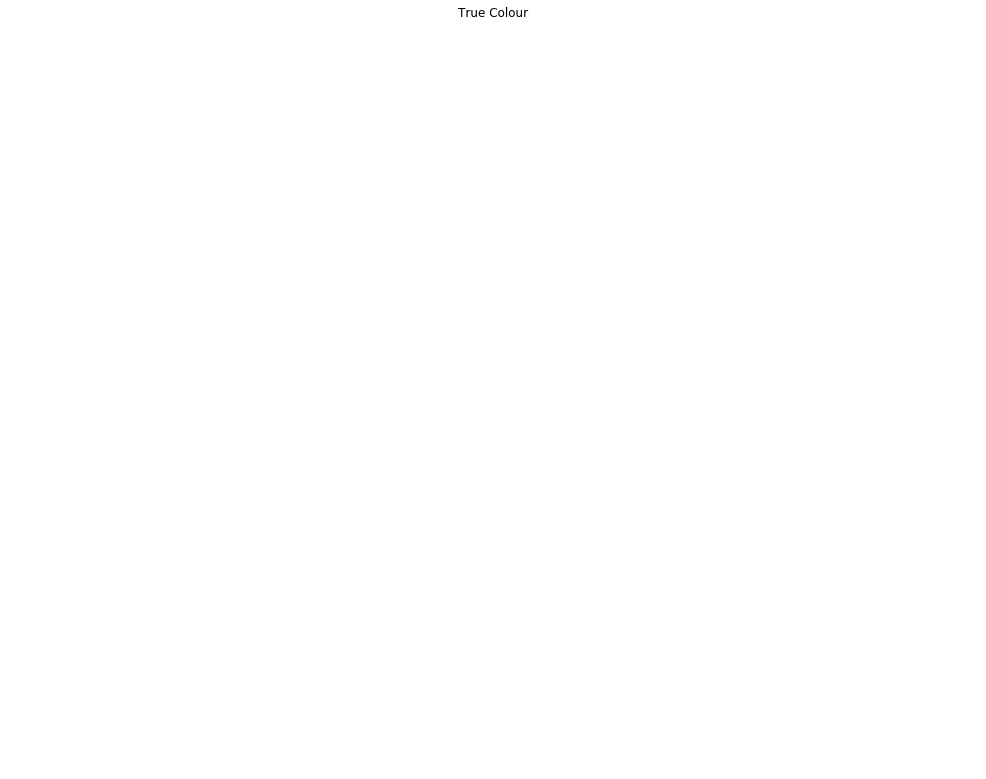

In [8]:
data_lst8_once = Masked_lst8_data.isel(time=5)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [9]:
#Do tassled Cap transformation
TCI = TasseledCapTools.thresholded_tasseled_cap(Masked_lst8_data,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)
tcw = TCI['wetness']




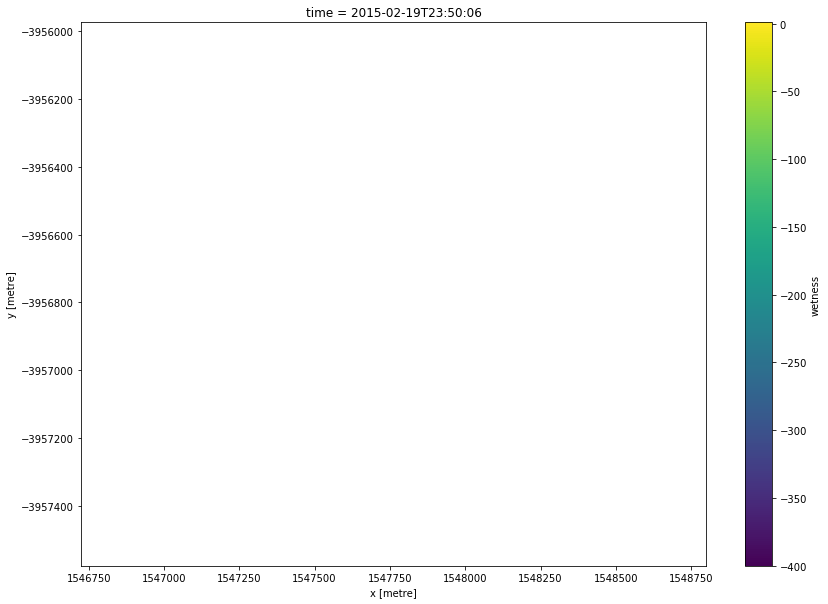

In [10]:
tcw.isel(time=5).plot(cmap='viridis', figsize =(14,10),vmin=-400, vmax=1)

In [11]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 181, y: 64, x: 83)>
array([[[-22.9995, -17.4397, ..., -22.0357, -22.1152],
        [-20.6493, -19.3062, ..., -22.7988, -18.0997],
        ...,
        [  5.086 ,   6.0471, ...,   0.681 , -13.1708],
        [  3.5717,   6.2005, ...,  -0.1011, -20.1227]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[-22.7566, -16.9255, ..., -23.2848, -21.8957],
        [-21.4286, -19.399 , ..., -23.5655, -19.1547],
        ...,
        [  4.462 ,   4.7086, ...,  -1.7795, -11.8469],
        [  3.1632,   4.8516, ...,  -6.4827, -15.6015]],

       [[-21.5039, -16.8134, ..., -21.6461, -22.5799],
        [-20.0894, -19.0395, ..., -20.9307, -20.7467],
        ...,
        [  4.4682,   4.8373, ...,   0.033 ,  -9.5922],
        [  2.9381,   5.0482, ...,  -5.9283, -15.2395]]])
Co

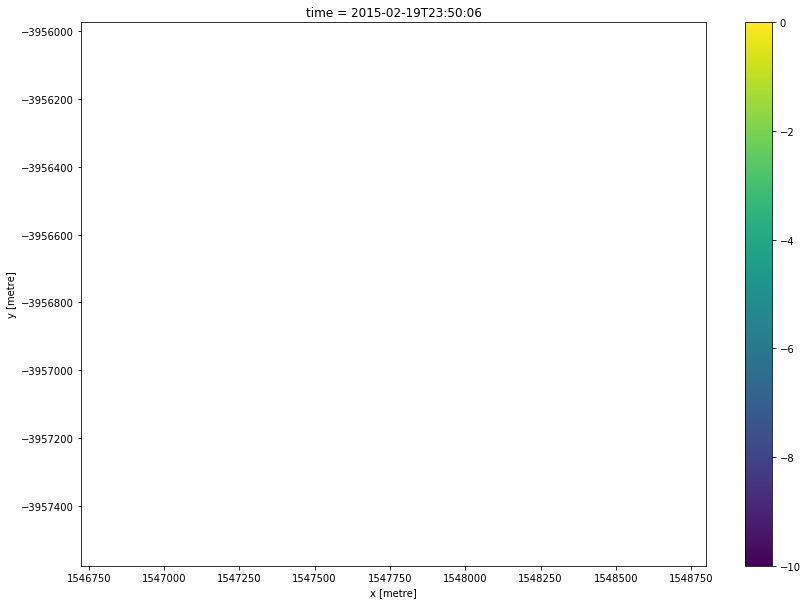

In [12]:
lst_fisher.isel(time=5).plot(cmap='viridis', figsize =(14,10),vmin=-10,)

In [13]:
inundated_veg_msk = (np.logical_and(lst_fisher>=-10,tcw>=-400))
inundated_veg = lst_fisher.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

In [14]:
all_sumed = (inundated_veg.sum(dim='x').sum(dim='y')).to_dataframe(name='data')
all_sumed

,data
time,
2015-01-02 23:50:19.500,53.0
2015-01-09 23:56:31.000,0.0
2015-01-18 23:50:17.000,106.0
2015-01-25 23:56:25.000,0.0
2015-02-03 23:50:13.500,0.0
2015-02-19 23:50:06.000,0.0
2015-02-26 23:56:15.500,66.0
2015-03-07 23:49:59.000,175.0
2015-03-14 23:56:04.000,61.0


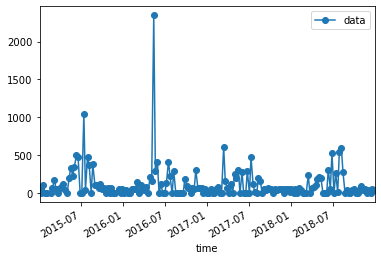

In [15]:
all_sumed.plot(marker='o')

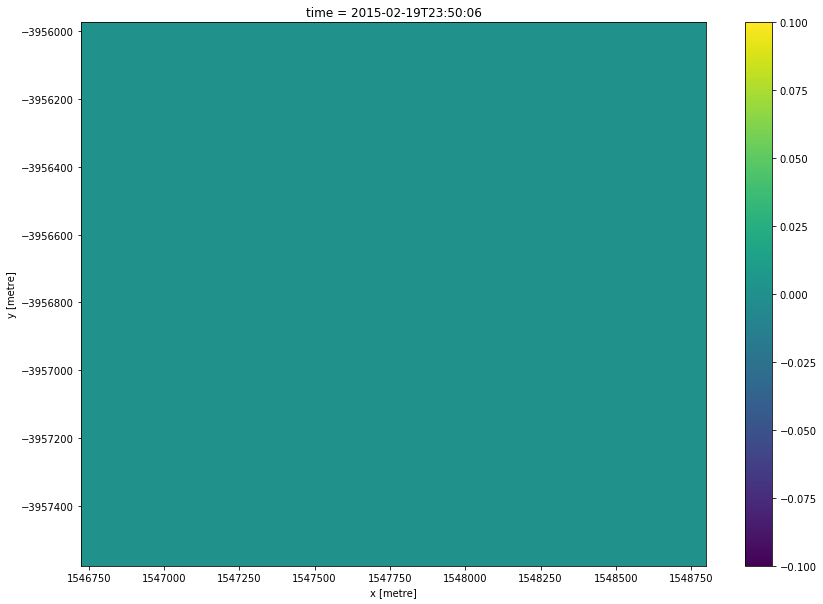

In [16]:
inundated_veg.isel(time=5).plot(cmap='viridis', figsize =(14,10))

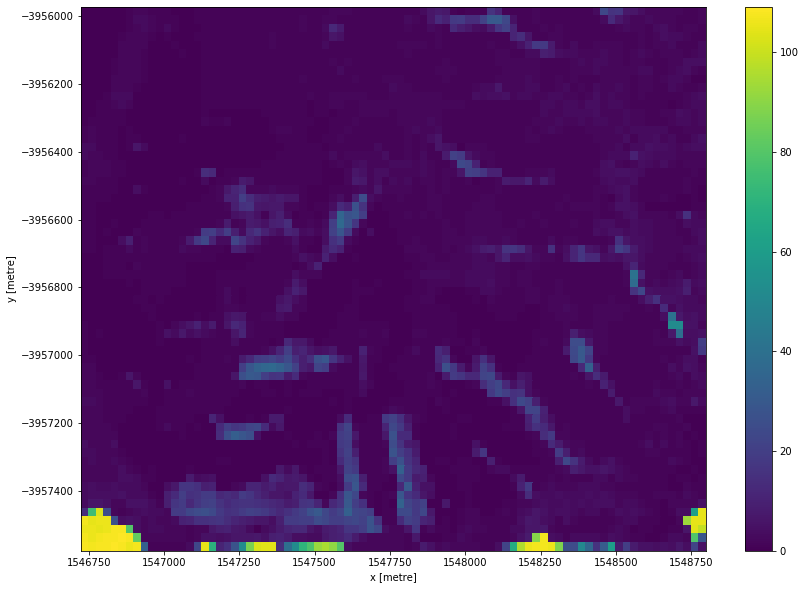

In [17]:
wet_frequency = inundated_veg.sum(dim='time')
wet_frequency.plot(cmap='viridis', figsize =(14,10))

In [24]:
#define area of interest
query2 = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
   
        #Tuross Head
# 'y': (-36.01, -36.092),
# 'x': (150.047, 150.186), 
    
    #Pambula wetlands
# 'y': (-36.924, -36.988),
# 'x': (149.848, 149.925), 
    
     #Pambula small shadow
# 'y': (-36.950, -36.990),
# 'x': (149.830, 149.880),    
  
 #Black Mountain SHadow
'y': (-35.272, -35.284),
'x': (149.088, 149.109),  
    
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

#ACT LArge
# 'y': (-35.216, -35.414),
# 'x': (149.040, 149.309),      
    
    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2015-06-11', '2015-06-12'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [25]:
#load data
data_lst82 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query2)
data_lst82

<xarray.Dataset>
Dimensions:          (time: 1, x: 83, y: 64)
Coordinates:
  * time             (time) datetime64[ns] 2015-06-11T23:49:33
  * y                (y) float64 -3.956e+06 -3.956e+06 ... -3.958e+06 -3.958e+06
  * x                (x) float64 1.547e+06 1.547e+06 ... 1.549e+06 1.549e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 223 184 201 234 254 ... 547 671 504 320
    blue             (time, y, x) int16 156 145 190 212 239 ... 505 681 467 282
    green            (time, y, x) int16 267 282 331 363 357 ... 705 947 734 524
    red              (time, y, x) int16 305 297 388 441 449 ... 724 1034 720 565
    nir              (time, y, x) int16 1472 1590 1810 1842 ... 1096 1138 1548
    swir1            (time, y, x) int16 950 899 1107 1323 ... 1346 1061 1297
    swir2            (time, y, x) int16 493 483 618 726 770 ... 790 1143 821 865
Attributes:
    crs:      EPSG: 3577

In [26]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst82 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst82.copy(deep=True).where(~want_to_mask, np.NaN)

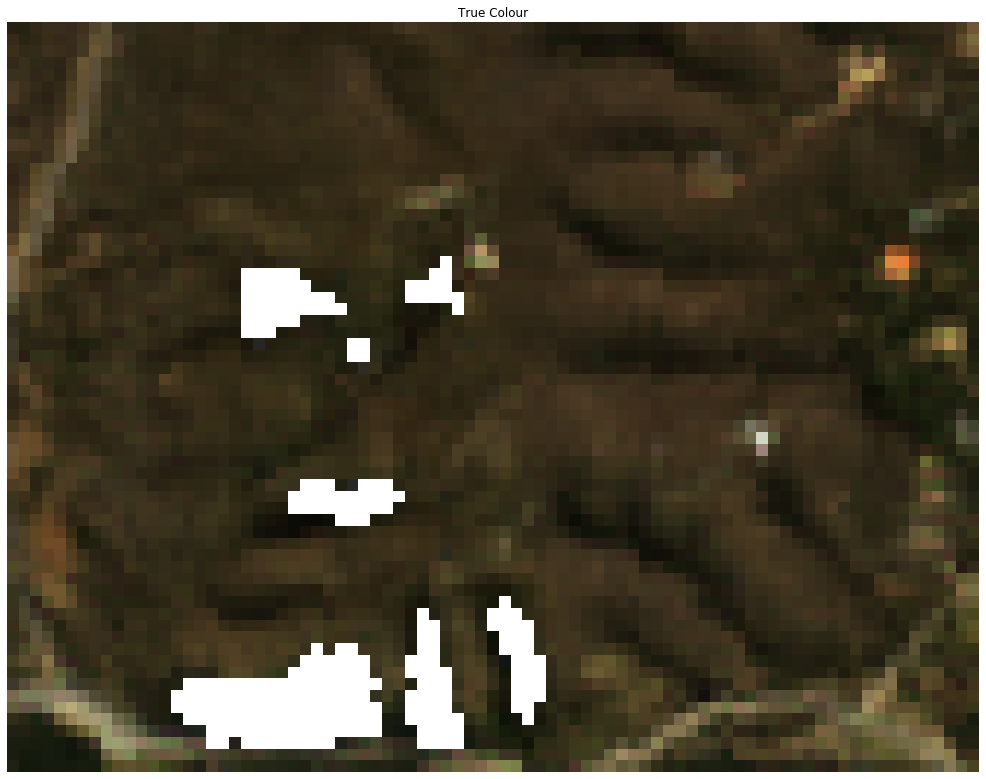

In [27]:
data_lst8_once = terrain_out.isel(time=0)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

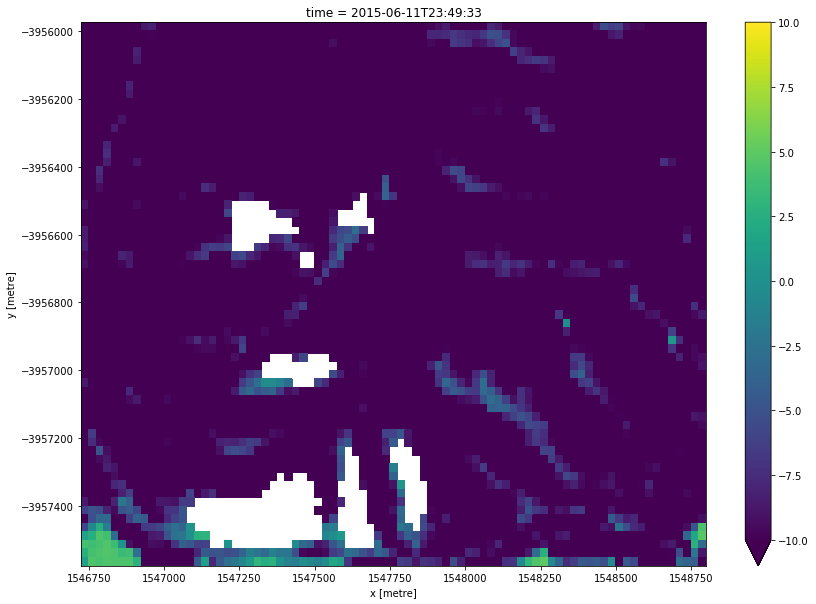

In [29]:
#make Fisher index

lst_fisher = (lambda terrain_out: 1.7204 +((171*terrain_out['green'])+(3*terrain_out['red'])-(70*terrain_out['nir'])-(45*terrain_out['swir1'])-(71*terrain_out['swir2']))/10000)(terrain_out)
lst_fisher.plot(cmap='viridis', figsize =(14,10), vmin=-10)